In [5]:
import requests
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim import models
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import datetime as dt
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
# read in scraped sec data
data = pd.read_csv("sec_descriptions.csv")

# Prepare Data for Topic Modeling

In [88]:
# strip punctuation from descriptions
data["descriptions"] = data["descriptions"].str.replace('[^\w\s]','')

In [6]:
# split descriptions into words and convert to lowercase
words = [[words for words in str(row).split()] for row in data['descriptions'].str.lower()]

In [7]:
# lemmatize and remove stop words
lemmatizer = WordNetLemmatizer()

docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in words]

# get stop words
stop_words = stopwords.words('english')
stop_words = stop_words + ['inc', 'business', 'company', 'llc', 'together', 'went', 'two', 'three', 'service', 'operates', 'provides', 'four', 'known', 'formerly', 'america', 'american', 'united', 'state', 'internationally', 'subsidiary', 'service', 'solution', 'north', 'engages', 'ltd', 'wa', 'develops', 'acquired', 'product', 'corp', 'based', 'manufacture', 'design', 'worldwide', 'also', 'including', 'new', 'could', 'may', 'u', 'ha']

docs = [[token for token in doc if token not in stop_words] for doc in docs]

In [8]:
# get bigrams and trigrams and add them to docs
bigrams = gensim.models.phrases.Phrases(docs, min_count=5, threshold=10)
trigram = gensim.models.phrases.Phrases(bigrams[docs], min_count=2)

In [9]:
# view bigrams and trigrams
# import operator
# sorted(
#     {k:v for k,v in trigram.vocab.items() if '_' in k if v>=trigram.min_count}.items(),
#     key=operator.itemgetter(1),
#     reverse=True)

In [10]:
# add bigrams and trigrams to docs
for i in range(len(docs)):
    for token in trigram[docs[i]]:
        if '_' in token:
            docs[i].append(token)

In [11]:
# create dictionary
dictionary = corpora.Dictionary(docs)

# remove words that occur in more than 50% of documents 
# or that occur less than 10 times
# keep only top 100,000 to speed up model performance
dictionary.filter_extremes(no_above=0.5, no_below=10, keep_n=100000)

In [12]:
# create corpus 
corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in docs]

In [6]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1045859
Number of documents: 15076


## Perform LDA Topic Modeling

In [40]:
# train the lda model with 40 topics and 100 iterations
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    random_state=100,
    num_topics=40,
    passes=1,
    chunksize=3000,
    eta=None,
    eval_every=None,
    iterations=100,
    gamma_threshold=0.001,
    per_word_topics=True)

In [34]:
len(top_topics)

40

In [6]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
38    -0.070765 -0.045007       1        1  8.557600
15    -0.065089 -0.015646       2        1  8.535687
19    -0.110148  0.199388       3        1  8.392954
10    -0.103781  0.196717       4        1  7.905691
21    -0.087144  0.157444       5        1  5.473250
29    -0.050246 -0.045758       6        1  4.726350
25    -0.102191 -0.090293       7        1  4.049903
34    -0.087734  0.136609       8        1  3.961754
1     -0.058119 -0.046380       9        1  3.173160
14    -0.037183 -0.099003      10        1  3.122892
27    -0.058245 -0.069139      11        1  3.055280
18    -0.031321 -0.060133      12        1  3.028954
23    -0.068677  0.129019      13        1  2.982246
12    -0.057088 -0.029597      14        1  2.811870
16    -0.036196 -0.049854      15        1  2.776299
6     -0.058072  0.044120      16        1  2.655364
22    -0.034959 -0.004399      17        1  2.558861
5     -0.076668 -0.024191      18        1  2.463332
17    -0.031985 -0.035581      19        1  2.008060
37    -0.032290 -0.071601      20        1  1.996180
26    -0.099435 -0.063379      21        1  1.982763
30    -0.026812 -0.057336      22        1  1.811448
2     -0.067506 -0.064094      23        1  1.790452
28    -0.025699  0.044971      24        1  1.780093
11    -0.064983 -0.091350      25        1  1.723577
0     -0.027915 -0.015010      26        1  1.712377
13    -0.009980 -0.043997      27        1  1.230068
32     0.029893 -0.083375      28        1  1.188795
20    -0.027466  0.038924      29        1  1.024867
35     0.108337 -0.012751      30        1  0.531531
24     0.068284 -0.053493      31        1  0.295399
9      0.119094  0.027539      32        1  0.243479
8      0.059788  0.040848      33        1  0.134836
31     0.038466  0.098859      34        1  0.076686
36     0.147886 -0.006739      35        1  0.070819
39     0.136651  0.003846      36        1  0.060337
33     0.123975  0.001751      37        1  0.050832
4      0.158823 -0.006703      38        1  0.037443
3      0.231742 -0.001297      39        1  0.018046
7      0.384757  0.066072      40        1  0.000465, topic_info=                 Term           Freq          Total Category  logprob  loglift
100136       customer  417254.000000  417254.000000  Default  30.0000  30.0000
100239     investment  236629.000000  236629.000000  Default  29.0000  29.0000
100848      insurance  144111.000000  144111.000000  Default  28.0000  28.0000
7175          patient  222300.000000  222300.000000  Default  27.0000  27.0000
6899         clinical  227853.000000  227853.000000  Default  26.0000  26.0000
...               ...            ...            ...      ...      ...      ...
101063     technology       0.163630  202229.112147  Topic40  -7.8303  -1.7491
100367           risk       0.157959  177558.047541  Topic40  -7.8656  -1.6543
100059  approximately       0.151230  145568.306253  Topic40  -7.9091  -1.4992
100160       employee       0.148489  172339.048044  Topic40  -7.9274  -1.6863
100362         result       0.147372  199854.354501  Topic40  -7.9350  -1.8420

[3676 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
30060       1  0.078574              024
30060       2  0.004622              024
30060       3  0.010785              024
30060       4  0.018488              024
30060       5  0.009244              024
...       ...       ...              ...
35822      20  0.961691  york_washington
35822      25  0.002255  york_washington
73946      23  0.978681      young_fleet
52040      23  0.981076  zonal_isolation
120303     14  0.988243           zulily

[42686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[39, 16, 20, 11, 22, 30, 26, 35, 2, 15, 28, 19, 24, 13, 17, 7, 23, 6, 18, 38, 27, 31, 3, 29, 12, 1, 14, 33,

# Get topics for every year 2017-2022

In [20]:
# get year column
data['year'] = data['date'].str[:4]

In [21]:
tw17 = data[data['year'] == '2017']
tw18 = data[data['year'] == '2018']
tw19 = data[data['year'] == '2019']
tw20 = data[data['year'] == '2020']
tw21 = data[data['year'] == '2021']
tw22 = data[data['year'] == '2022']

In [22]:
# check that we've captured all data
tw17.shape[0] +tw18.shape[0] + tw19.shape[0] + tw20.shape[0] + tw21.shape[0] + tw22.shape[0]

15076

In [23]:
# lemmatize and remove stop words
lemmatizer = WordNetLemmatizer()

# get stop words
stop_words = stopwords.words('english')
stop_words = stop_words + ['inc', 'business', 'company', 'llc', 'together', 'went', 'two', 'three', 'service', 'operates', 'provides', 'four', 'known', 'formerly', 'america', 'american', 'united', 'state', 'internationally', 'subsidiary', 'service', 'solution', 'north', 'engages', 'ltd', 'wa', 'develops', 'acquired', 'product', 'corp', 'based', 'manufacture', 'design', 'worldwide', 'also', 'including', 'new', 'could', 'may']

def get_dict(desc_column):
    # split descriptions into words and convert to lowercase
    words = [[words for words in str(row).split()] for row in desc_column.str.lower()]
    # lemmatize
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in words]
    docs = [[token for token in doc if token not in stop_words] for doc in docs]
    bigrams = gensim.models.phrases.Phrases(docs, min_count=5, threshold=10)
    trigram = gensim.models.phrases.Phrases(bigrams[docs], min_count=2)
    for i in range(len(docs)):
        for token in trigram[docs[i]]:
            if '_' in token:
                docs[i].append(token)
                
    # create dictionary
    dictionary = corpora.Dictionary(docs)

    # remove words that occur in more than 50% of documents
    dictionary.filter_extremes(no_above=0.5, no_below=10, keep_n=100000)
    
    # create corpus 
    corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in docs]
    
    return docs, dictionary, corpus

In [ ]:
tw17docs, tw17dict, tw17corp = get_dict(tw17['descriptions'])
tw18docs, tw18dict, tw18corp = get_dict(tw18['descriptions'])
tw19docs, tw19dict, tw19corp = get_dict(tw19['descriptions'])
tw20docs, tw20dict, tw20corp = get_dict(tw20['descriptions'])
tw21docs, tw21dict, tw21corp = get_dict(tw21['descriptions'])
tw22docs, tw22dict, tw22corp = get_dict(tw22['descriptions'])

# Get Topic Rankings For Every Year 2017-2022

In [42]:
def get_topic_rankings(docs, dicty):
    
    # get a list of the rankings from every company for the year
    results = []
    for i in range(0,len(docs)):
        results = lda_model[dicty.doc2bow(docs[i])][0]
    
    # gather results across companies into a dict
    res = defaultdict(list)
    for i, j in results:
        res[i].append(j)
    
    # find the average value for each topic in a given year
    topic_mean = {key : float(sum(values)) / len(values) for key, values in res.items() if len(values) != 0}
    
    # sort with most popular topics at top
    topic_mean = sorted(topic_mean.items(), key=lambda x: x[1], reverse=True)
    
    return results, topic_mean

In [43]:
tw17_results, tw17_mean = get_topic_rankings(tw17docs, tw17dict)
tw18_results, tw18_mean = get_topic_rankings(tw18docs, tw18dict)
tw19_results, tw19_mean = get_topic_rankings(tw19docs, tw19dict)
tw20_results, tw20_mean = get_topic_rankings(tw20docs, tw20dict)
tw21_results, tw21_mean = get_topic_rankings(tw21docs, tw21dict)
tw22_results, tw22_mean = get_topic_rankings(tw22docs, tw22dict)

In [49]:
# convert to dataframes

tw17_df = pd.DataFrame(tw17_mean, columns=['Topic', '2017'])
tw18_df = pd.DataFrame(tw18_mean, columns=['Topic', '2018'])
tw19_df = pd.DataFrame(tw19_mean, columns=['Topic', '2019'])
tw20_df = pd.DataFrame(tw20_mean, columns=['Topic', '2020'])
tw21_df = pd.DataFrame(tw21_mean, columns=['Topic', '2021'])
tw22_df = pd.DataFrame(tw22_mean, columns=['Topic', '2022'])

In [126]:
# merge em all together
all_years = tw17_df.merge(tw18_df, on='Topic', how='outer').merge(tw19_df, on='Topic', how='outer').merge(tw20_df, on='Topic', how='outer').merge(tw21_df, on='Topic', how='outer').merge(tw22_df, on='Topic', how='outer')

In [127]:
# get topic keywords

topics = []

for index, topic in lda_model.show_topics(formatted=False, num_words= 15, num_topics=-1):
    tupe = (index, [w[0] for w in topic])
    topics.append(tupe)

In [128]:
topics = pd.DataFrame(topics, columns=['Topic', 'Keywords'])

In [129]:
all_years = all_years.merge(topics, on='Topic')
all_years.fillna(0,inplace=True)

# Track topic prominence over time 2017-2022

In [130]:
pd.set_option('display.max_colwidth', None)

all_years.sort_values(by="Topic", ascending=True)

Topic      2017      2018      2019      2020      2021      2022  \
19      0  0.000000  0.000000  0.016597  0.000000  0.028335  0.000000   
15      1  0.014136  0.000000  0.000000  0.020135  0.000000  0.000000   
21      5  0.000000  0.000000  0.000000  0.079535  0.000000  0.000000   
9       6  0.032230  0.000000  0.000000  0.041831  0.021938  0.055178   
14     10  0.015347  0.000000  0.000000  0.000000  0.000000  0.000000   
13     12  0.016392  0.041665  0.059134  0.078892  0.015970  0.014080   
5      14  0.060205  0.038582  0.020186  0.033760  0.064172  0.017911   
0      15  0.228379  0.090913  0.157966  0.103717  0.192509  0.111738   
3      16  0.074492  0.102296  0.114485  0.069732  0.127805  0.076374   
7      17  0.035608  0.000000  0.057111  0.029082  0.000000  0.000000   
6      18  0.054234  0.051394  0.071917  0.103535  0.069049  0.048641   
20     20  0.000000  0.000000  0.013425  0.000000  0.000000  0.000000   
8      21  0.035117  0.039670  0.054040  0.053037  0.046595  0.349060   
10     22  0.029925  0.016102  0.081427  0.072777  0.022997  0.010332   
1      23  0.175910  0.015225  0.000000  0.013583  0.031314  0.000000   
22     24  0.000000  0.000000  0.000000  0.029444  0.000000  0.000000   
4      25  0.073160  0.017829  0.000000  0.017069  0.000000  0.000000   
18     27  0.000000  0.016266  0.000000  0.000000  0.017317  0.000000   
16     29  0.000000  0.052969  0.070094  0.027181  0.100131  0.000000   
23     30  0.000000  0.000000  0.000000  0.016465  0.000000  0.000000   
24     31  0.000000  0.000000  0.000000  0.014067  0.029968  0.000000   
25     32  0.000000  0.000000  0.000000  0.012447  0.042875  0.000000   
17     33  0.000000  0.029861  0.055141  0.000000  0.000000  0.000000   
11     34  0.024068  0.013407  0.000000  0.000000  0.052436  0.177124   
26     36  0.000000  0.000000  0.000000  0.000000  0.041052  0.000000   
12     37  0.016982  0.079159  0.042552  0.120946  0.026248  0.071426   
2      38  0.106838  0.377770  0.142489  0.062249  0.041338  0.041315   

                                                                                                                                                       Keywords  
19                        [network, customer, cpe, data, communication, market, provider, technology, access, system, provide, mobile, video, wireless, device]  
15               [insurance, risk, reinsurance, insurer, loss, financial, premium, policy, claim, market, group, capital, underwriting, regulation, investment]  
21                                  [property, reit, income, tax, tenant, year, taxable, subject, federal, real, lease, distribution, share, gain, shareholder]  
9                       [care, health, healthcare, patient, program, medicare, law, hospital, payment, provider, federal, physician, medical, regulation, plan]  
14                   [patient, clinical, trial, drug, fda, study, clinical_trial, cell, approval, patent, treatment, development, cancer, candidate, agreement]  
13                     [brand, store, customer, consumer, market, sale, retail, marketing, distribution, information, fiscal, believe, well, program, culinary]  
5                  [gas, oil, property, natural, well, reserve, operation, production, 31, development, interest, december, approximately, oil_gas, regulation]  
0         [customer, data, platform, technology, information, sale, market, software, employee, application, provide, consumer, believe, management, marketing]  
3                  [vehicle, customer, aircraft, market, truck, believe, operation, industry, employee, fleet, sale, regulation, management, contract, provide]  
7                    [station, market, network, advertising, television, restaurant, fcc, programming, local, revenue, content, radio, 1, satellite, agreement]  
6                                [silica, mining, customer, operation, facility, market, energy, plant, gas, cost, mine, environmental, project, permit, water]  
20             

In [132]:
all_years_long = pd.melt(all_years, id_vars=['Topic', 'Keywords'], value_vars=['2017', '2018', '2019', '2020', '2021', '2022'])

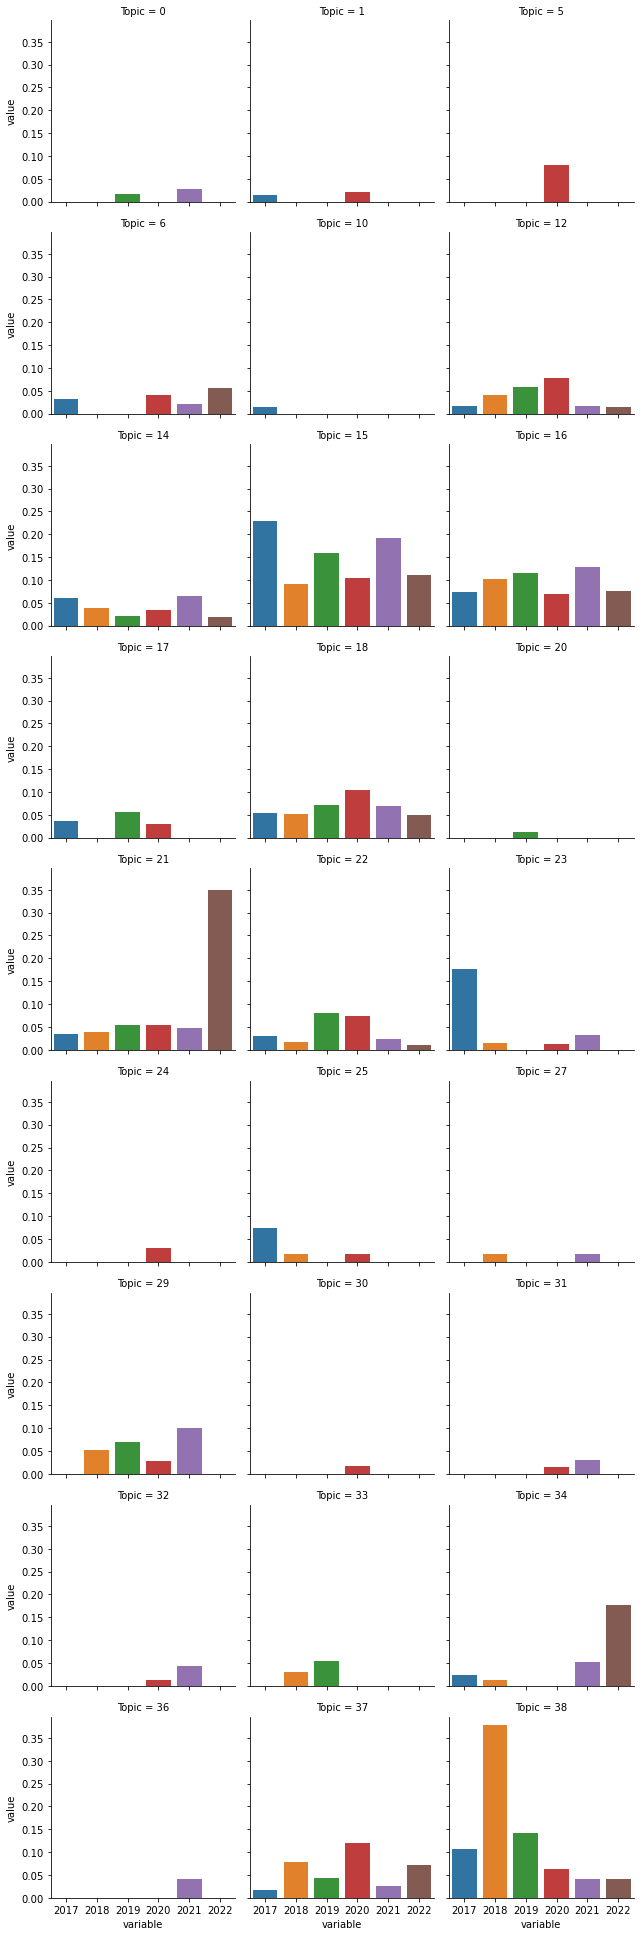

In [133]:
sea = sns.FacetGrid(all_years_long, hue = 'variable', col = "Topic", col_wrap=3)
 
sea.map(sns.barplot, "variable", "value",
        order = ["2017", "2018", "2019", "2020", "2021", "2022"]);

# Match topics back with the companies

In [60]:
# match the topics back with the companies

def link_topics(model, corpus, descriptions):
    
    # initialize df
    df = pd.DataFrame()    
    
    for i, row in enumerate(model.get_document_topics(corpus)):
        
        # sort by topic importance
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, proportion) in enumerate(row):
            # if most important topic
            if j == 0:
                #concat the keywords
                words = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in words])
                df = df.append(pd.Series([int(topic_num), round(proportion,4), topic_keywords]), ignore_index=True)
            else:
                break
    df.columns = ['Dominant_Topic', "Percent_Contrib", "Topic_Keywords"]
    
    # add in doc id and contents
    df = pd.concat([df.reset_index(drop=True), descriptions.reset_index(drop=True)], axis=1)
          
    
    return(df)

In [90]:
company_topics = link_topics(lda_model, corpus, data)

# Link topics to price data

In [107]:
price = pd.read_csv('price.csv')

In [98]:
# clean company name
company_topics['company'] = company_topics['company'] .str.lower()
company_topics['company'] = company_topics['company'] .str.replace('[^\w\s]','')

In [97]:
# merge with descriptions to get SEDOL ID
company_topics_ = pd.merge(company_topics, descriptions[['Name','ID']],left_on='company',right_on='Name',how='left')

## Reduce price data to 2017-2022 and get cumsum

In [102]:
# set index to date
price = price.set_index(['Date'])
price = price.sort_index()

# get year
price['year'] = pd.DatetimeIndex(price.index).year

# keep years 2017-2022
after_2017 = price[price['year'].isin([2017, 2018, 2019, 2020, 2021, 2022])]

# forward fill and backfill 
after_2017 = after_2017.ffill().bfill()

# calculate percent change for each row
price_change = after_2017.diff().cumsum()
pct_change = price_change / after_2017.iloc[0]

# drop year column
after_2017_ = pct_change.drop('year', 1)

# remove first row
after_2017_ = after_2017_.iloc[1: , :]

In [189]:
# print all topics and counts

pd.set_option('display.max_rows', 36)  
pd.set_option('display.max_colwidth', None)

topic_counts = company_topics_.groupby(['Dominant_Topic', 'Topic_Keywords']).size().reset_index(name="Count")
topic_counts

Dominant_Topic  \
0                0   
1                1   
2                2   
3                3   
4                5   
5                6   
6                8   
7                9   
8               10   
9               11   
10              12   
11              13   
12              14   
13              15   
14              16   
15              17   
16              18   
17              19   
18              20   
19              21   
20              22   
21              23   
22              24   
23              25   
24              26   
25              27   
26              28   
27              29   
28              30   
29              32   
30              34   
31              35   
32              36   
33              37   
34              38   
35              39   

                                                                                                                 Topic_Keywords  \
0                                          network, customer, cpe, communication, data, provider, market, video, access, mobile   
1                                       insurance, risk, reinsurance, insurer, loss, financial, premium, policy, claim, capital   
2                                                 oil, gas, drilling, operation, well, regulation, oil_gas, rig, water, natural   
3                                            customer, million, market, system, 2017, financial, operation, ebix, year, officer   
4                                                  property, real, income, reit, tenant, tax, estate, real_estate, asset, lease   
5                                         care, health, healthcare, patient, program, hospital, medicare, law, payment, federal   
6                           insurance, claim, worker, worker_compensation, employee, customer, policy, information, agent, risk   
7   carrier, motor_carrier, transportation, logistics, driver, freight, customer, shipment, truckload, transportation_logistics   
8                                         patient, clinical, trial, study, drug, fda, cell, clinical_trial, approval, treatment   
9                            development, home, market, construction, property, community, operating, believe, sale, management   
10                                             brand, customer, food, sale, store, culinary, market, distribution, believe, fsp   
11                                      customer, store, sale, believe, market, cruise, distribution, offer, experience, center   
12                                                    gas, oil, property, natural, reserve, interest, well, production, 31, net   
13                             customer, data, platform, technology, information, software, sale, application, employee, market   
14                                   vehicle, contract, customer, aircraft, fleet, market, operation, employee, truck, aviation   
15                              station, restaurant, market, advertising, network, television, local, programming, fcc, revenue   
16                                          mining, customer, energy, operation, facility, mine, plant, market, silica, project   
17                            drug, fda, clinical, patent, trial, approval, development, agreement, application, clinical_trial   
18                                      program, student, institution, education, title, school, iv, university, regulation, ed   
19                                               drug, clinical, fda, patent, trial, patient, treatment, study, approval, phase   
20                 technology, system, customer, market, application, manufacturing, power, semiconductor, process, development   
21                                         fsp, technology, development, clinical, test, patent, fda, application, cell, market   
22                              contract, drillships, driller, vantage, project, pipeline, drillship, jackup_rig, gas, dayrates   
23                                      inves

# Plot return of each dominant topic

In [103]:
def plot_topic(topic_no):

    topic = company_topics_[company_topics_['Dominant_Topic'] == topic_no]
        
    topics = list(set(topic['ID'].to_list()))
    topics = [x for x in topics if str(x) != 'nan']

    topic_ = after_2017_[topics]

    # plot to compare topic performance to total stock performance

    # get avg pct change across all stocks
    avg = after_2017_.mean(axis=1)
    # plot
    fig, ax = plt.subplots(figsize=(9,4))
    topic_.plot(ax=ax)
    avg.plot(ax=ax, color='black')
    ax.get_legend().remove()
    plt.show()

0


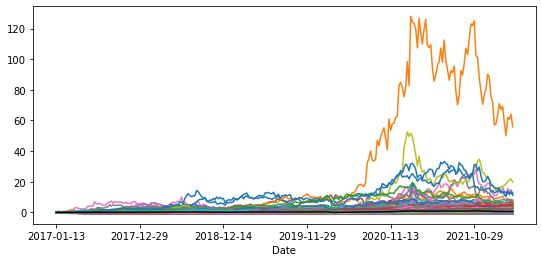

1


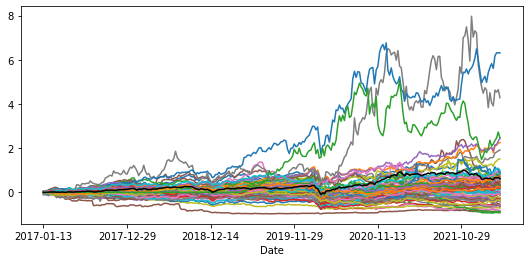

2


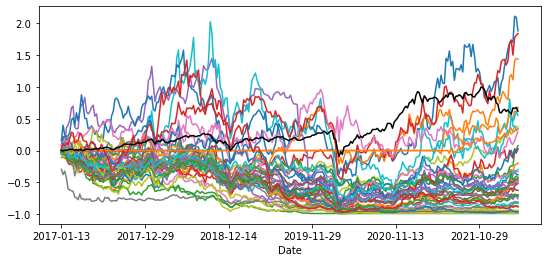

3


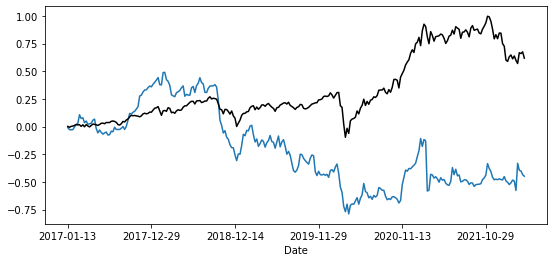

5


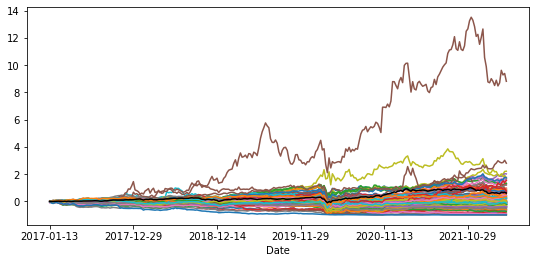

6


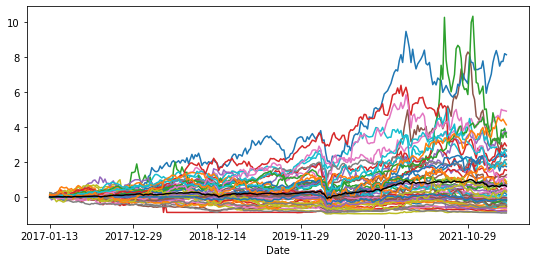

8


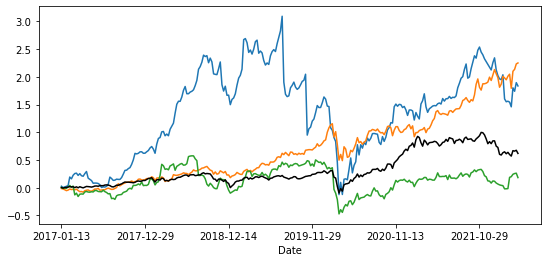

9


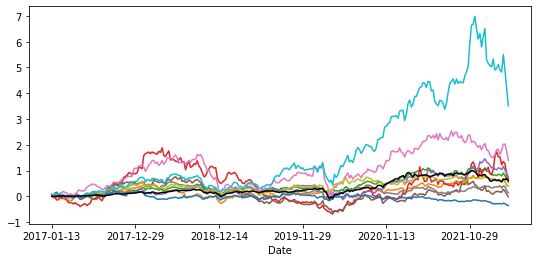

10


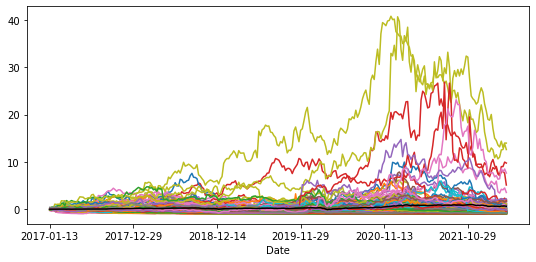

11


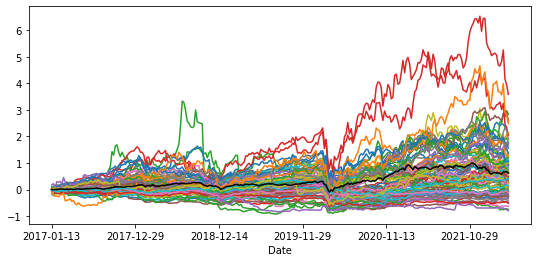

12


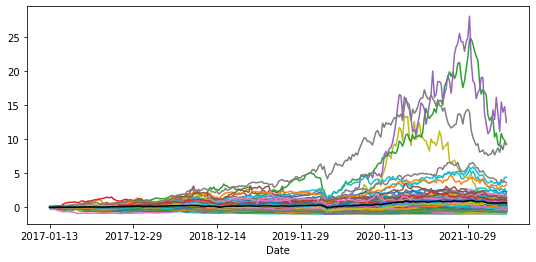

13


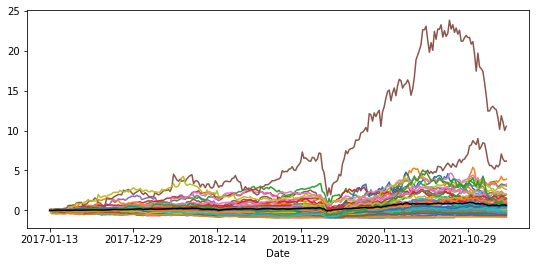

14


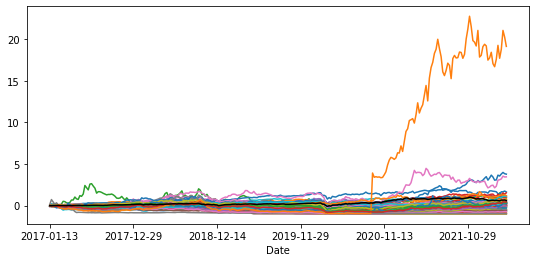

15


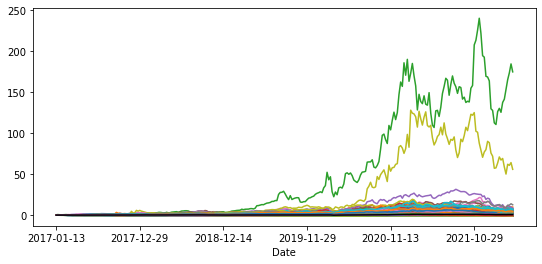

16


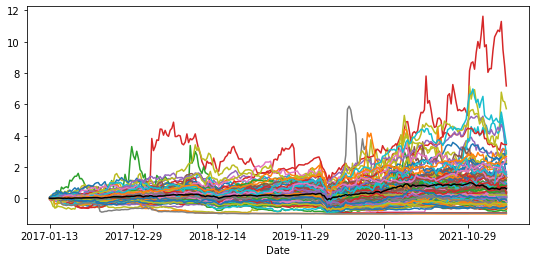

17


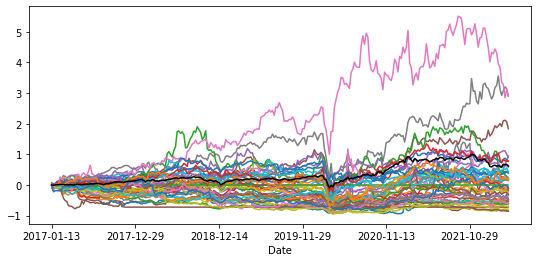

18


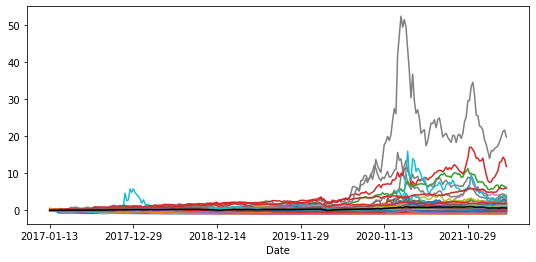

19


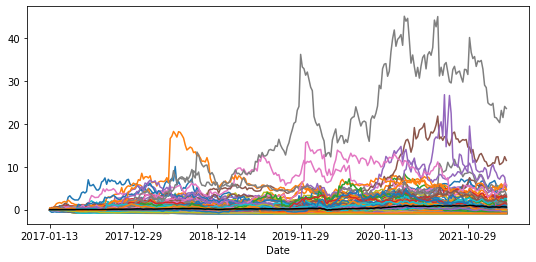

20


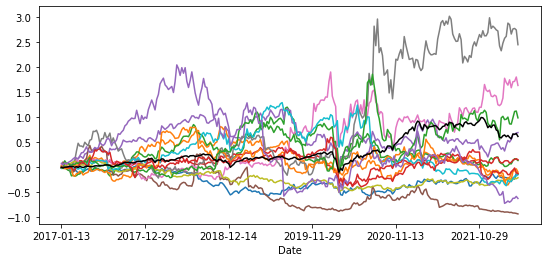

21


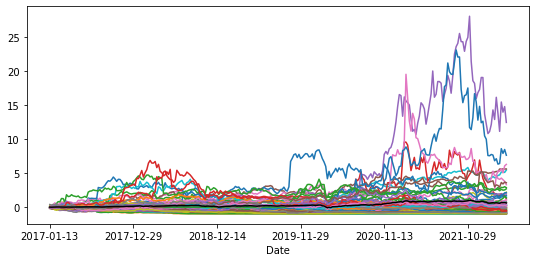

22


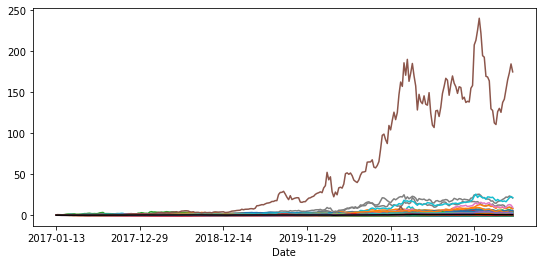

23


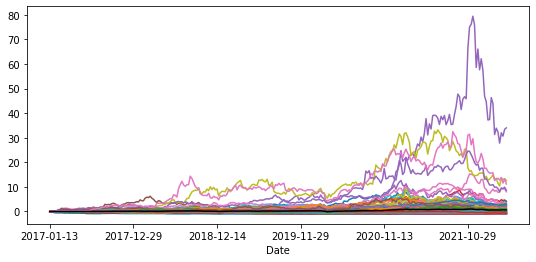

24


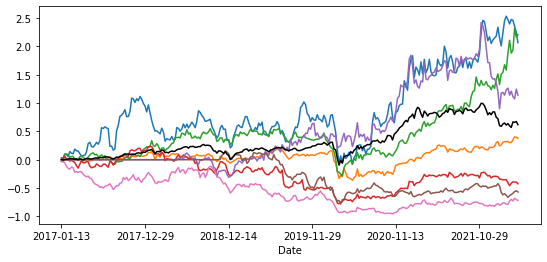

25


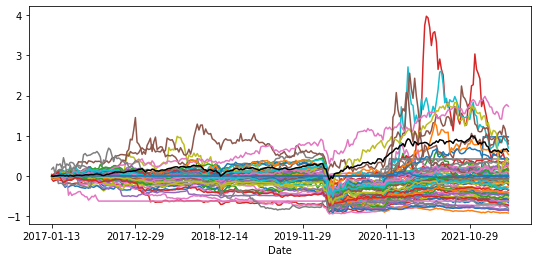

26


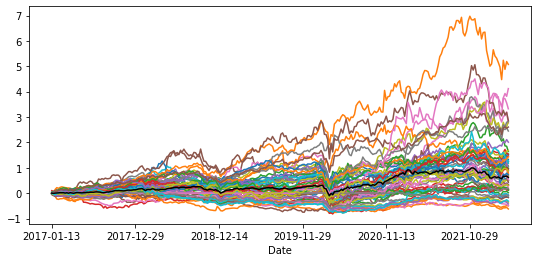

27


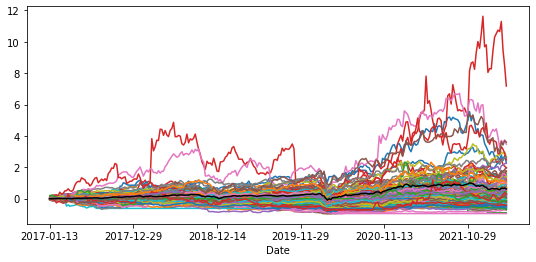

28


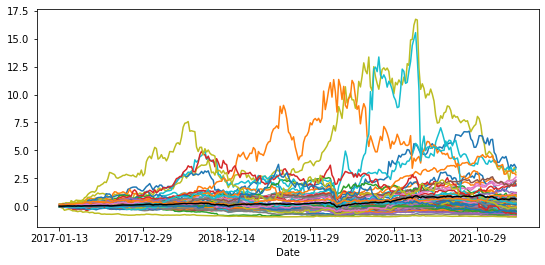

29


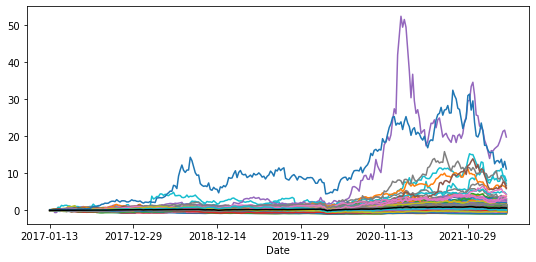

30


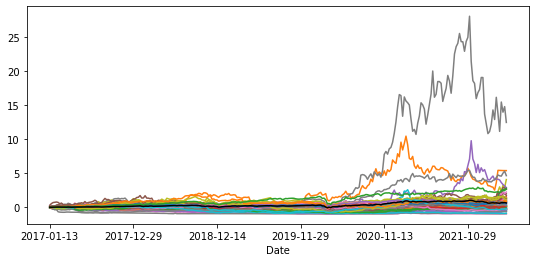

32


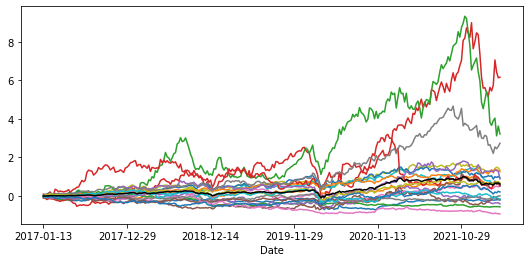

34


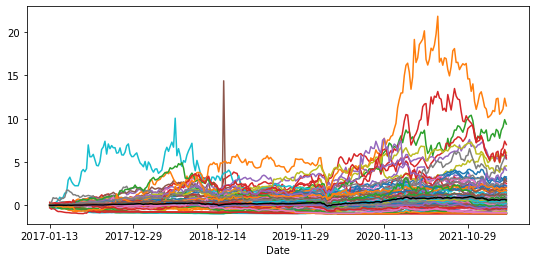

35


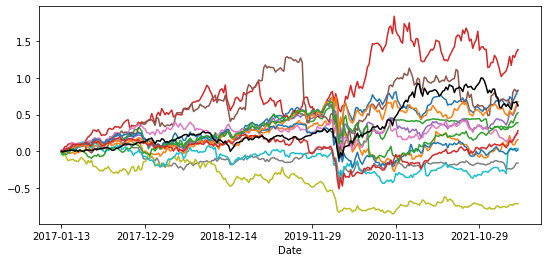

36


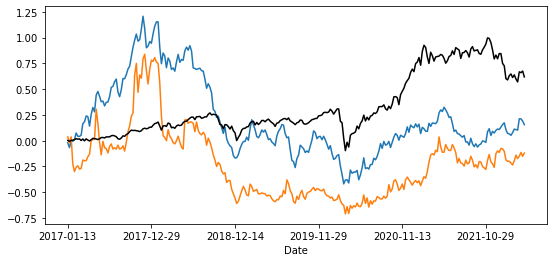

37


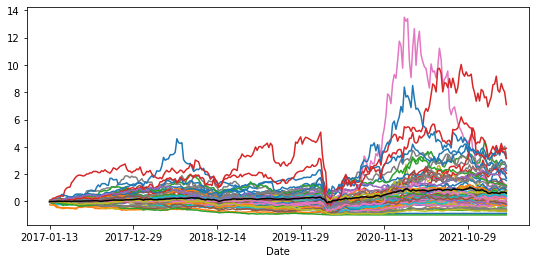

38


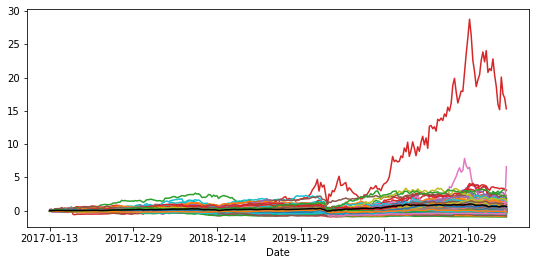

39


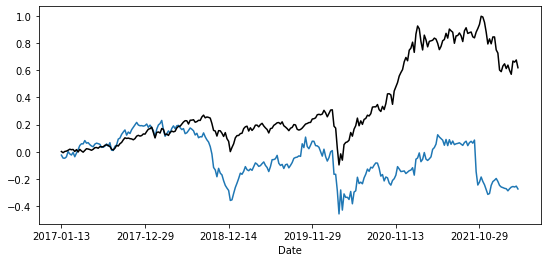

In [104]:
topic_list = list(set(company_topics_['Dominant_Topic'].to_list()))

for topic in topic_list:
    print(topic)
    plot_topic(topic)

# Plot average return of dominant topic compared to market

In [105]:
def compare_topic_avg(topic_no):

    topic = company_topics_[company_topics_['Dominant_Topic'] == topic_no]
        
    topics = list(set(topic['ID'].to_list()))
    topics = [x for x in topics if str(x) != 'nan']

    topic_ = after_2017_[topics]

    # plot to compare topic performance to total stock performance

    # get avg pct change across all stocks
    avg = after_2017_.mean(axis=1)
    avg_topic = topic_.mean(axis=1)
    # plot
    fig, ax = plt.subplots(figsize=(9,4))
    avg.plot(ax=ax, color='black')
    avg_topic.plot(ax=ax, color='blue')
    plt.show()

0


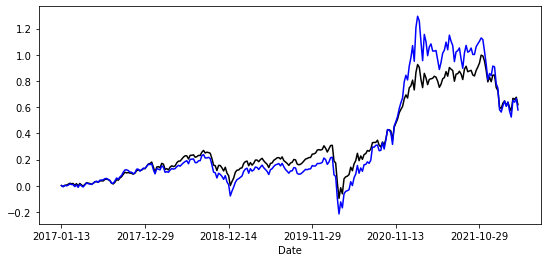

1


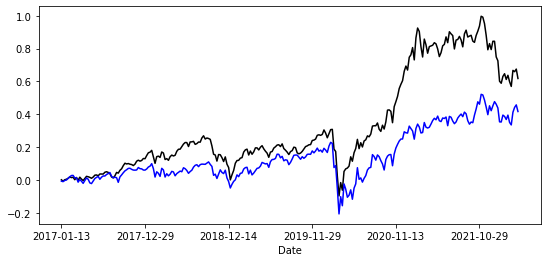

2


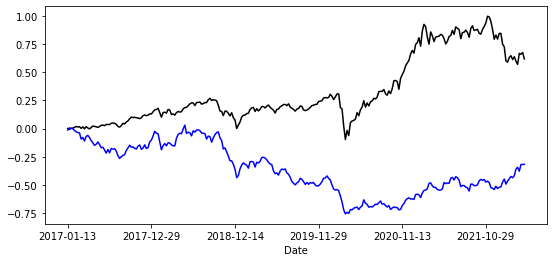

3


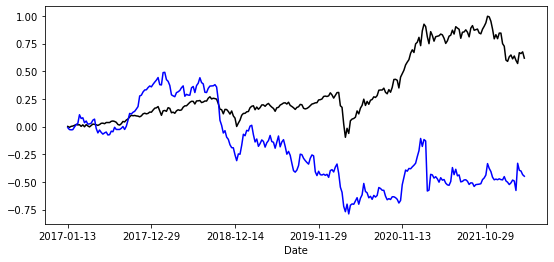

5


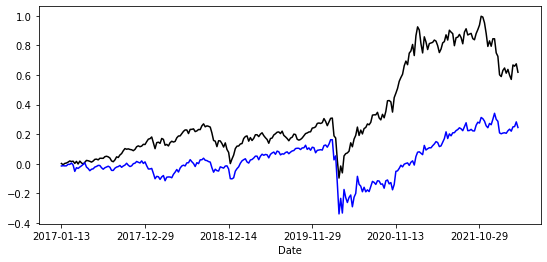

6


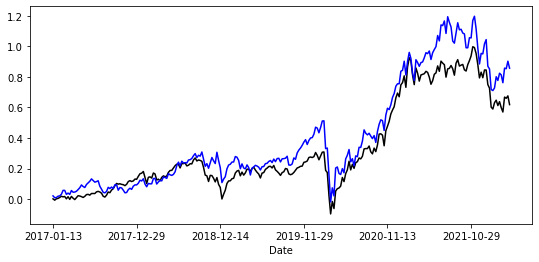

8


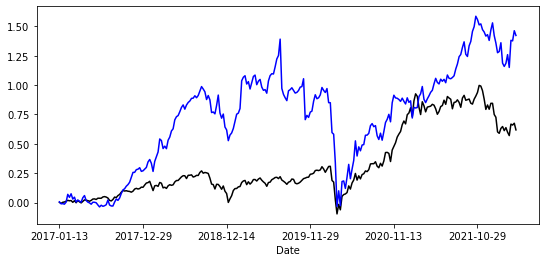

9


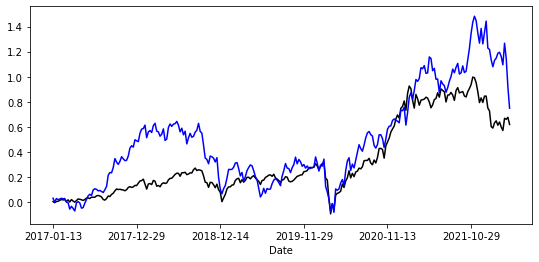

10


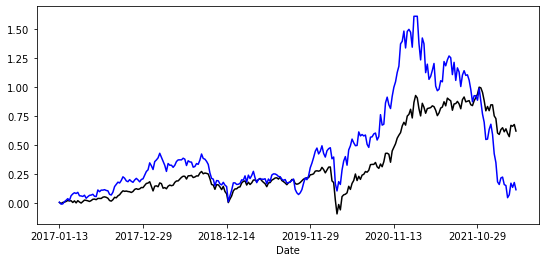

11


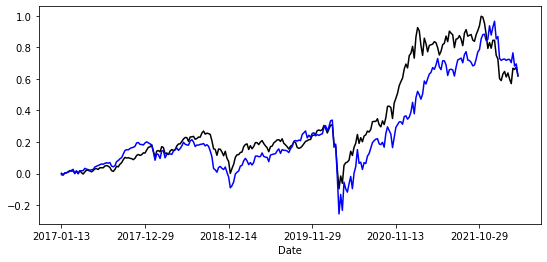

12


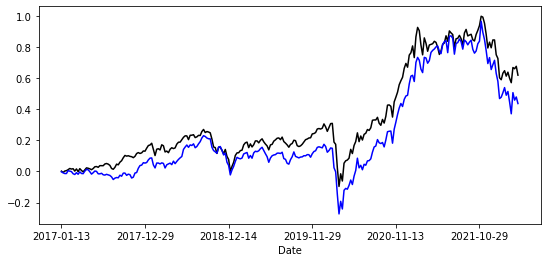

13


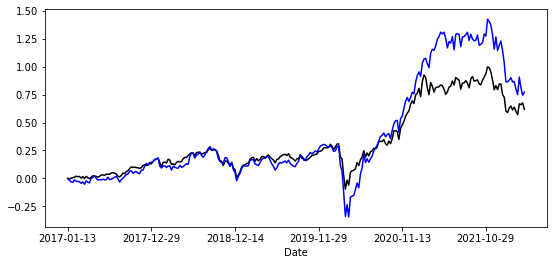

14


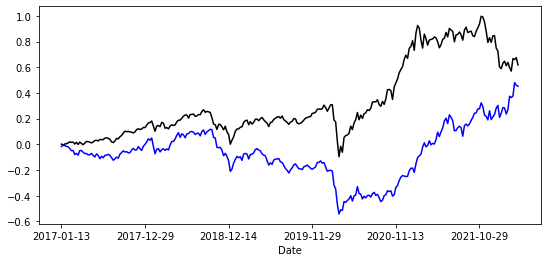

15


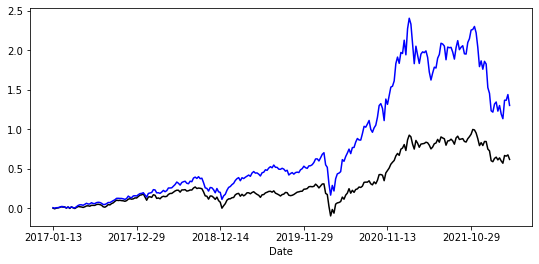

16


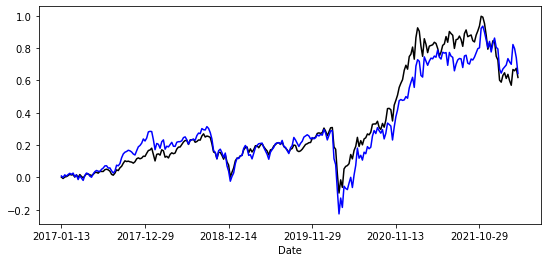

17


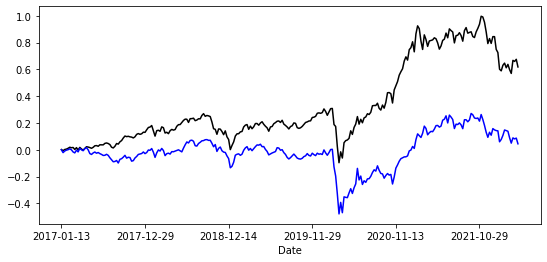

18


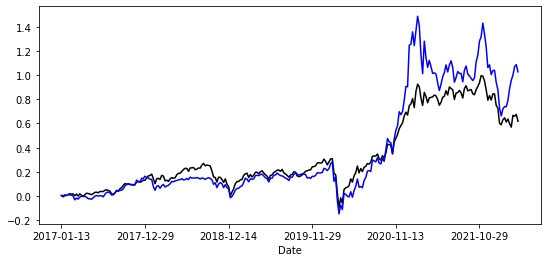

19


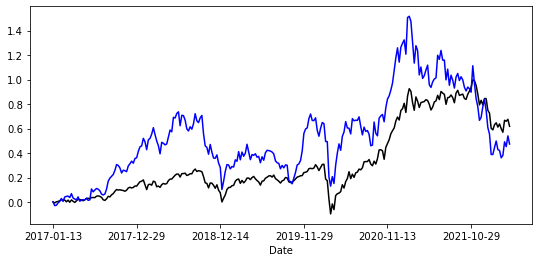

20


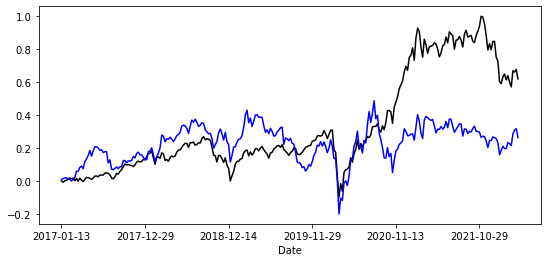

21


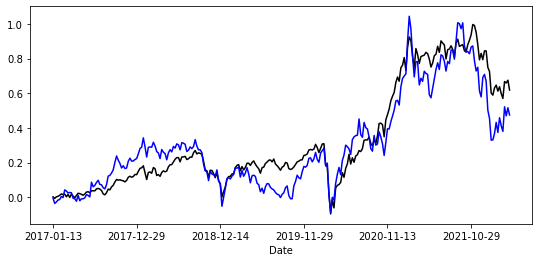

22


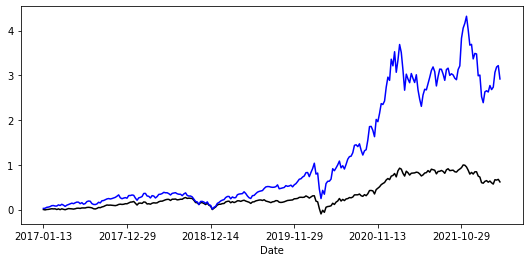

23


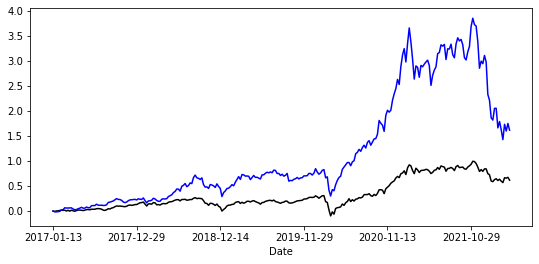

24


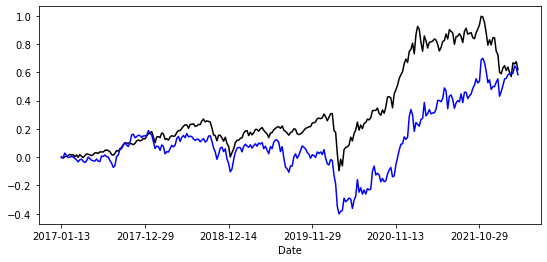

25


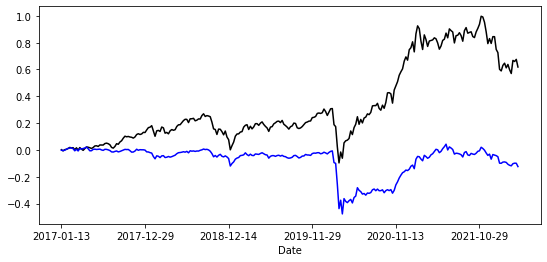

26


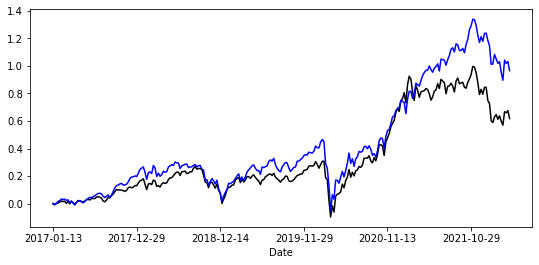

27


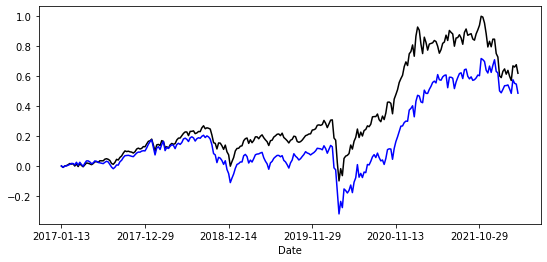

28


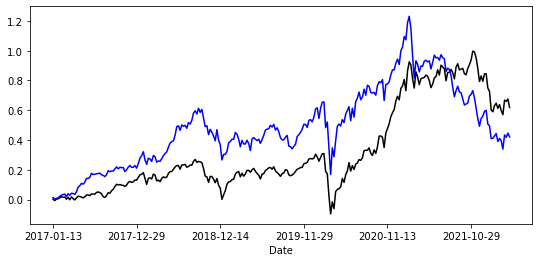

29


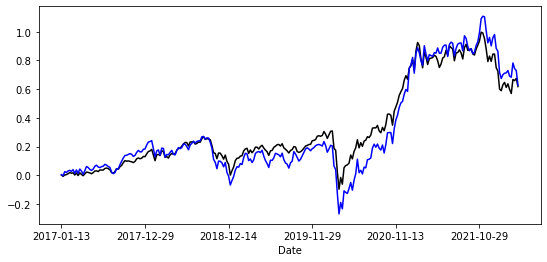

30


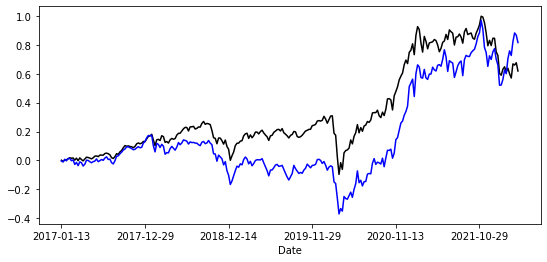

32


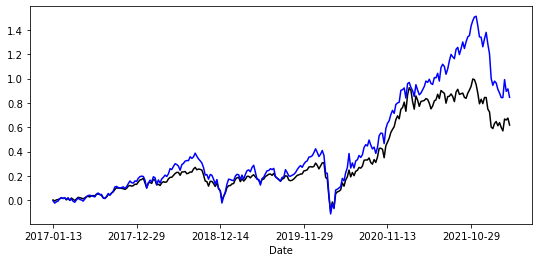

34


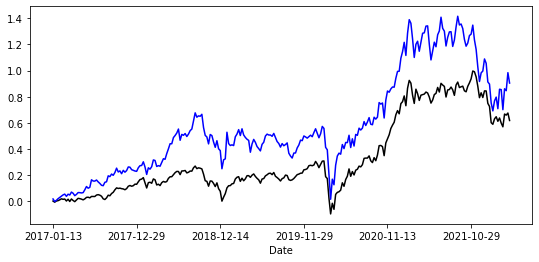

35


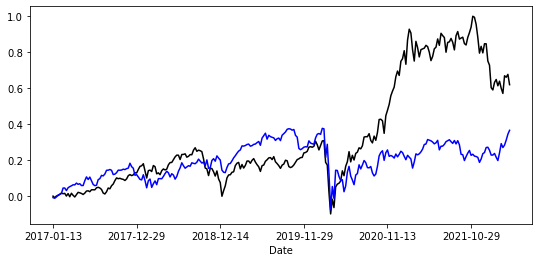

36


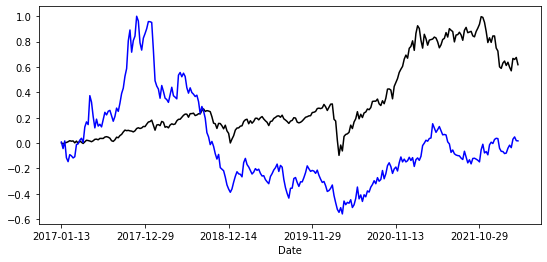

37


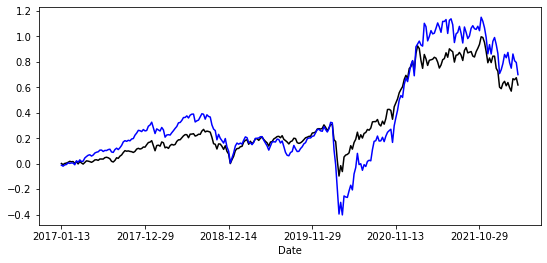

38


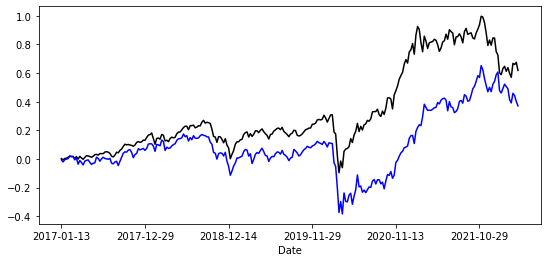

39


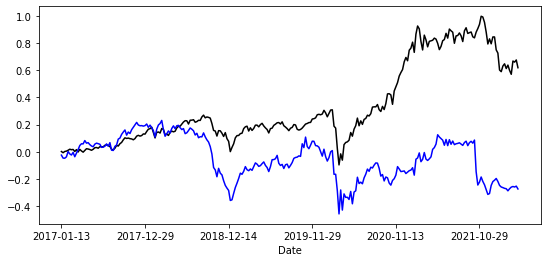

In [106]:
for topic in topic_list:
    print(topic)
    compare_topic_avg(topic)